# seq2seq evaluation, GPU or CPU

In [1]:
import unicodedata
import string
import re
import random
import time
import datetime
import math
import socket
hostname = socket.gethostname()

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence#, masked_cross_entropy
from masked_cross_entropy import *

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
# %matplotlib inline

In [2]:
from pathlib import Path
import pickle
dataset_path = Path('data/seq2seq')
tmp_path = dataset_path / 'tmp/'
!mkdir -p $tmp_path

In [3]:
import torch

USE_CUDA = torch.cuda.is_available(); 
# USE_CUDA = False; 

print(f'USE_CUDA={USE_CUDA}')

USE_CUDA=True


In [4]:
VOCAB, ENCODER, DECODER = ['vocab', 'encoder', 'decoder']
fn_trn1 = {VOCAB: 'eng-pol.vocab.p', \
           ENCODER: 'batched.encoder.h500.l2.e1000.gpu.torch', \
           DECODER: 'batched.decoder.h500.l2.e1000.gpu.torch'
          }
fn_dict = fn_trn1

## Loading data files

### Load vocab list

## Code

In [5]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

    def index_words(self, sentence):
        for word in sentence.split(' '):
            self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed: return
        self.trimmed = True
        
        keep_words = []
        
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words %s / %s = %.4f' % (
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.n_words = 3 # Count default tokens

        for word in keep_words:
            self.index_word(word)

In [6]:
# indexes_from_sentence

In [7]:
# Return a list of indexes, one for each word in the sentence, plus EOS
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] + [EOS_token]

In [8]:
MAX_LENGTH = 25

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout=0.1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=self.dropout, bidirectional=True)
        
    def forward(self, input_seqs, input_lengths, hidden=None):
        # Note: we run this all at once (over multiple batches of multiple sequences)
        embedded = self.embedding(input_seqs)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        outputs, hidden = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:] # Sum bidirectional outputs
        return outputs, hidden

In [10]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(this_batch_size, max_len)) # B x S

        if USE_CUDA:
            attn_energies = attn_energies.cuda()

        # For each batch of encoder outputs
        for b in range(this_batch_size):
            # Calculate energy for each encoder output
            for i in range(max_len):
                attn_energies[b, i] = self.score(hidden[:, b], encoder_outputs[i, b].unsqueeze(0))

        # Normalize energies to weights in range 0 to 1, resize to 1 x B x S
        # return F.softmax(attn_energies).unsqueeze(1)
        return F.softmax(attn_energies, dim=-1).unsqueeze(1)
    
#     def score(self, hidden, encoder_output):
        
#         if self.method == 'dot':
#             energy = hidden.dot(encoder_output)
#             return energy
        
#         elif self.method == 'general':
#             energy = self.attn(encoder_output)
#             energy = hidden.dot(energy)
#             return energy
        
#         elif self.method == 'concat':
#             energy = self.attn(torch.cat((hidden, encoder_output), 1))
#             energy = self.v.dot(energy)
#             return energy

    def score(self, hidden, encoder_output):
        if self.method == 'dot':
            energy =torch.dot(hidden.view(-1), encoder_output.view(-1))
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = torch.dot(hidden.view(-1), energy.view(-1))
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = torch.dot(self.v.view(-1), energy.view(-1))
        return energy

In [11]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=dropout)
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_seq, last_hidden, encoder_outputs):
        # Note: we run this one step at a time

        # Get the embedding of the current input word (last output word)
        batch_size = input_seq.size(0)
        embedded = self.embedding(input_seq)
        embedded = self.embedding_dropout(embedded)
        embedded = embedded.view(1, batch_size, self.hidden_size) # S=1 x B x N

        # Get current hidden state from input word and last hidden state
        rnn_output, hidden = self.gru(embedded, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs;
        # apply to encoder outputs to get weighted average
        attn_weights = self.attn(rnn_output, encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x S=1 x N

        # Attentional vector using the RNN hidden state and context vector
        # concatenated together (Luong eq. 5)
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = F.tanh(self.concat(concat_input))

        # Finally predict next token (Luong eq. 6, without softmax)
        output = self.out(concat_output)

        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [12]:
def evaluate(input_seq, max_length=MAX_LENGTH):
    # https://github.com/spro/practical-pytorch/issues/95
    # input_lengths = [len(input_seq)]
    
    # UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
    # https://discuss.pytorch.org/t/torch-no-grad/12296
    
    input_seqs = [indexes_from_sentence(input_lang, input_seq)]
    input_lengths = [len(input_seqs[0])]

    # input_batches = Variable(torch.LongTensor(input_seqs), volatile=True).transpose(0, 1)
    input_batches = Variable(torch.LongTensor(input_seqs)).transpose(0, 1)

    if USE_CUDA:
        input_batches = input_batches.cuda()

    # Set to not-training mode to disable dropout
    encoder.train(False)
    decoder.train(False)

    # Run through encoder
    with torch.no_grad():
        encoder_outputs, encoder_hidden = encoder(input_batches, input_lengths, None)

    # Create starting vectors for decoder
    # decoder_input = Variable(torch.LongTensor([SOS_token]), volatile=True) # SOS
    decoder_input = Variable(torch.LongTensor([SOS_token])) # SOS
    decoder_hidden = encoder_hidden[:decoder.n_layers] # Use last (forward) hidden state from encoder

    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Store output words and attention states
    decoded_words = []
    decoder_attentions = torch.zeros(max_length + 1, max_length + 1)

    # Run through decoder
    for di in range(max_length):
        with torch.no_grad():
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])

        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([ni]))
        if USE_CUDA: decoder_input = decoder_input.cuda()

    # Set back to training mode
    encoder.train(True)
    decoder.train(True)
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

# load vocab

In [13]:
vocab = pickle.load( open( tmp_path / fn_dict[VOCAB], 'rb' ) )
print(vocab.keys())
input_lang = vocab['input_lang']
output_lang = vocab['output_lang']

dict_keys(['input_lang', 'output_lang'])


## Load model

In [14]:
encoder = torch.load(tmp_path / fn_dict[ENCODER])
print(encoder)

EncoderRNN(
  (embedding): Embedding(1281, 500)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1, bidirectional=True)
)


In [15]:
decoder = torch.load(tmp_path / fn_dict[DECODER])
print(decoder)

LuongAttnDecoderRNN(
  (embedding): Embedding(1535, 500)
  (embedding_dropout): Dropout(p=0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear(in_features=1000, out_features=500, bias=True)
  (out): Linear(in_features=500, out_features=1535, bias=True)
  (attn): Attn()
)


In [16]:
encoder.gru.flatten_parameters()
decoder.gru.flatten_parameters()

# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

In [17]:
import io
import torchvision
from PIL import Image

In [18]:
# def show_plot_visdom():
#     buf = io.BytesIO()
#     plt.savefig(buf)
#     buf.seek(0)
#     attn_win = 'attention (%s)' % hostname
#     vis.image(torchvision.transforms.ToTensor()(Image.open(buf)), win=attn_win, opts={'title': attn_win})

In [19]:
def show_attention(input_sentence, output_words, attentions):
    mpl.style.use('default')
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    cax = ax.matshow(attentions.numpy(), cmap='jet') # cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

In [20]:
def evaluate_and_show_attention(input_sentence, target_sentence=None):
    output_words, attentions = evaluate(input_sentence)
    output_sentence = ' '.join(output_words)
    print('>', input_sentence)
    if target_sentence is not None:
        print('=', target_sentence)
    print('<', output_sentence)
    
    show_attention(input_sentence, output_words, attentions)
    
    # Show input, target, output text in visdom
#     win = 'evaluted (%s)' % hostname
#     text = '<p>&gt; %s</p><p>= %s</p><p>&lt; %s</p>' % (input_sentence, target_sentence, output_sentence)
#     vis.text(text, win=win, opts={'title': win})

## Translate text

> i failed after all .
= nie udało mi się jednak .
< nie udało mi się jednak . <EOS>


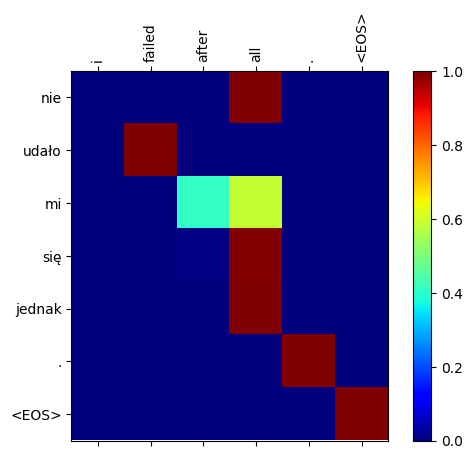

In [21]:
evaluate_and_show_attention('i failed after all .', 'nie udało mi się jednak .')